In [44]:
import networkx as nx
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import pennylane_ionq as ionq
import torch

# Create a graph
G = nx.Graph()

# Add a smaller set of nodes
nodes = ['A', 'B', 'C', 'D', 'E']
G.add_nodes_from(nodes)

# Add edges with weights (reduced set)
edges = [
    ('A', 'B', 1), ('A', 'C', 1), ('B', 'C', 1),
    ('B', 'D', 1), ('C', 'D', 1), ('C', 'E', 1)
]

# Add edges to the graph
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

# Define the QAOA parameters
n_qubits = len(nodes)
n_layers =  15  # Increased number of layers

# Define the cost Hamiltonian
def cost_hamiltonian(G):
    coeffs = []
    obs = []
    for i, j, w in G.edges(data='weight'):
        coeffs.append(w)
        obs.append(qml.PauliZ(nodes.index(i)) @ qml.PauliZ(nodes.index(j)))
    return qml.Hamiltonian(coeffs, obs)

# Define the QAOA ansatz
def qaoa_layer(gamma, beta):
    # Apply cost Hamiltonian
    for i, j in G.edges():
        qml.MultiRZ(2 * gamma * G.edges[i, j]['weight'], wires=[nodes.index(i), nodes.index(j)])
    # Apply mixer Hamiltonian
    for i in range(n_qubits):
        qml.RX(2 * beta, wires=i)

# Initialize the quantum device
## dev = ionq.SimulatorDevice(target="simulator.aria-1", api_key="YGDYh7Da8ofgZHhYHfJv2TIbHgrrHojV", wires=n_qubits, shots=1000)
dev = qml.device('default.qubit', wires = n_qubits)

# Define the cost function
@qml.qnode(dev)
def cost_function(params):
    gammas = params[:n_layers]
    betas = params[n_layers:]
    for gamma, beta in zip(gammas, betas):
        qaoa_layer(gamma, beta)
    return qml.expval(cost_hamiltonian(G))

# Function to print the ansatz
@qml.qnode(dev)
def print_ansatz(params):
    gammas = params[:n_layers]
    betas = params[n_layers:]
    for gamma, beta in zip(gammas, betas):
        qaoa_layer(gamma, beta)
    return qml.probs(wires=range(n_qubits))

# Initialize the parameters (increased number of layers)
np.random.seed(1685421)
params = np.random.rand(2*n_layers)

probs = print_ansatz(params)
print("Initial probabilities:", probs)



Initial probabilities: [0.05493635 0.02348622 0.03492143 0.01990214 0.04191345 0.0332517
 0.01678792 0.0045305  0.0128427  0.10869739 0.04719614 0.00270872
 0.05456895 0.06305222 0.0064645  0.01206732 0.03492143 0.01990214
 0.09910668 0.09156442 0.01678792 0.0045305  0.01486665 0.07093817
 0.04719614 0.00270872 0.00325016 0.00240364 0.0064645  0.01206732
 0.02142376 0.01454021]


init params [0.59748072 0.21385202 0.40501933 0.80044428 0.68361235 0.22938535
 0.4298385  0.10648847 0.43934024 0.12408817 0.72425131 0.01513237
 0.35189637 0.45404157 0.83078854 0.09152589 0.14578167 0.82911318
 0.71975245 0.15039239 0.15025286 0.57715142 0.57157197 0.43243214
 0.12237076 0.13637095 0.40138716 0.78863676 0.55680303 0.0797069 ]
Step  20	 Cost_L = -0.5382143
Step  40	 Cost_L = -0.5393813
Step  60	 Cost_L = -0.5642350
Step  80	 Cost_L = -1.1557794
Step 100	 Cost_L = -1.3352049
Final optimized parameters: tensor([0.5975, 0.2265, 0.4446, 0.7373, 0.6409, 0.1765, 0.3616, 0.1274, 0.4438,
        0.1873, 0.7814, 0.0694, 0.3298, 0.4267, 0.8314, 0.1312, 0.1510, 0.8486,
        0.6839, 0.1584, 0.1797, 0.6169, 0.5956, 0.4437, 0.1354, 0.1110, 0.3788,
        0.8437, 0.5948, 0.0466], grad_fn=<SubBackward0>)
Final cost: -1.3352049488563316
Final probabilities: [1.47565866e-02 3.55152353e-03 3.74881248e-02 9.41040001e-03
 2.59636336e-02 2.22825597e-02 2.80979867e-02 1.82479685e-02
 4

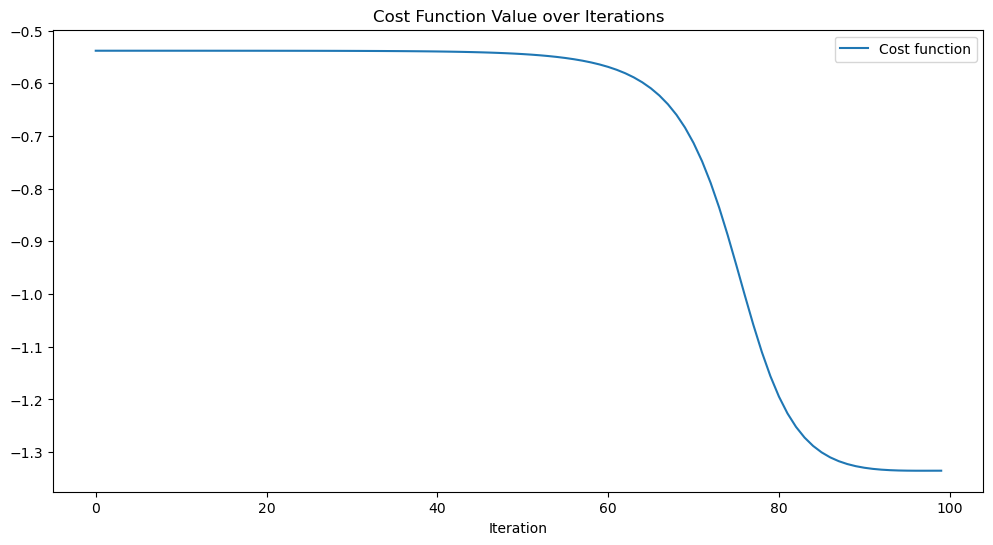

In [45]:
np.random.seed(1685421)
params = np.random.rand(2*n_layers)
print("init params",params)

# Function definitions
def hessian(cost_fn, params):
    return torch.autograd.functional.hessian(cost_fn, params)

def jacobian(cost_fn, params):
    return torch.autograd.functional.jacobian(cost_fn, params)

def phi_parameterization(params):
    pi = np.pi
    return torch.clip(params, -1.5*pi, 1.5*pi)

# Convert initial parameters to torch tensor (as float32 or float64)
phi_arr = torch.tensor(params, dtype=torch.float32, requires_grad=True)

steps = 100
eta = 0.0009
delta = 15e-7
alpha = 2 * eta
phi_len = len(params)
epsmin = 1e-13
epsmax = 1e13
I = torch.eye(phi_len, dtype=torch.float32, requires_grad=False)

# Run the IPG optimization
K = torch.zeros((phi_len, phi_len), dtype=torch.float32, requires_grad=False)
cost_history = []

for jj in range(steps):
    hess = hessian(cost_function, phi_arr).float()  # Ensure Hessian is float32
    K = K - alpha * (torch.matmul(hess, K) - I)
    #print(jj,"K",K)
    Knp = K.detach().numpy()
    Kcorr = Knp
    #Kcorr = np.array(np.abs(Knp)>epsmin) * np.array(np.abs(Knp)<epsmax) * Knp + \
    #   np.array(np.abs(Knp)<=epsmin)*0.0 + np.array(np.abs(Knp)>=epsmax)*np.sign(Knp)*epsmax
    #print("Kcorr",Kcorr)
    Kcorr = torch.tensor(Kcorr, dtype=torch.float32, requires_grad=True)
    g = jacobian(cost_function, phi_arr).float()  # Ensure Jacobian is float32
    #print(jj,"g",g)
    phi_arr = phi_arr - delta * torch.matmul(Kcorr, g)
    #print(jj,"ph",phi_arr)
    cost = cost_function(phi_arr.detach().numpy())
    
    if (jj + 1) % (steps // 5) == 0 or jj == steps - 1:
        print(f"Step {jj+1:3d}\t Cost_L = {cost:0.7f}")
    cost_history.append(cost)

# Display the final results
print("Final optimized parameters:", phi_arr)
print("Final cost:", cost)
print("Final probabilities:", print_ansatz(phi_arr.detach().numpy()))

# Plot the cost over iterations
plt.figure(figsize=(12, 6))
plt.plot(cost_history, label='Cost function')
plt.xlabel('Iteration')
plt.title('Cost Function Value over Iterations')
plt.legend()
plt.show()


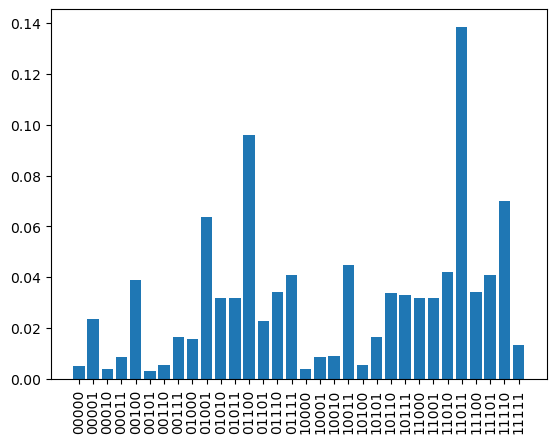

In [42]:
probs = print_ansatz(phi_arr.detach().numpy())
xvalues = [bin(j)[2:].zfill(len(nodes)) for j in range(2**len(nodes)) ]
plt.bar(xvalues, probs)
plt.xticks(rotation=90)
plt.show()


Best solution: [1, 1, 0, 1, 1]


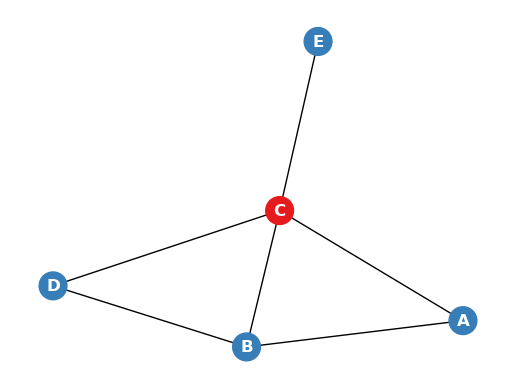

In [43]:
# get coloring for most probable state
idx_max = np.argmax(probs)
colors_ipg = [ int(b) for b in list(xvalues[idx_max]) ]
print("Best solution:", colors_ipg)

# plot IPG solution
fig, ax = plt.subplots()
pos = nx.spring_layout(G, seed=168421) 
colorlist = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"] 
nx.draw_networkx(G, pos,
        node_color=[colorlist[col] for col in colors_ipg],
        node_size=400, font_weight="bold", font_color="w",)
plt.axis("off")
plt.show()

Classical solution: {'s0': -1, 's1': 1, 's2': 1, 's3': -1, 's4': -1} 
(colors: [0, 1, 1, 0, 0])
(Minimum energy: -4.0


/var/folders/g3/08f8pgkj1gs3mvbsf29phb1m0000gn/T/ipykernel_55412/2794658833.py:39: DeprecationWarning: Call to deprecated function (or staticmethod) solve_ising. (You should use simulated annealing sampler of dwave-neal directly.) -- Deprecated since version 0.4.0.
  solution = solve_ising(linear, quad)


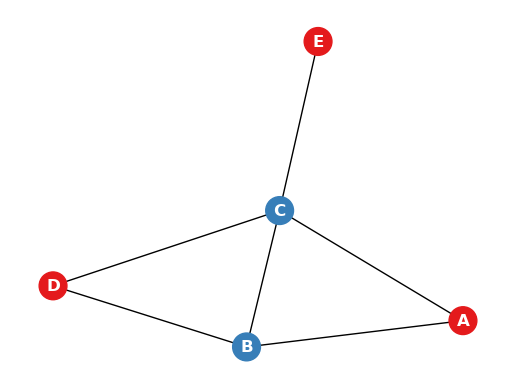

In [46]:
# classical solution using DWave's pyqubo and neal packages
#   (see bottom cells of qml_qaoa_intro.ipynb)
try:
    from pyqubo import Spin, solve_ising
except ImportError:
    print("pyqubo package not found ... it takes a while to get it installed")
    !pip install --quit pyqubo
    from pyqubo import Spin, solve_ising
try:
    import neal
except ImportError:
    print("DWave's neal package not found ... it takes a while to get it installed")
    !pip install --quit neal
    import neal

# build classical Ising Hamiltonian (input: Ising matrix J)
def build_classical_ising(J):
    # define classical spin variables
    spins = []
    N = J.shape[0]
    for ii in range(N):
        spin_name = "s" + str(ii)
        spins.append(Spin(spin_name))
    # build Ising Hamiltonian (here no linear terms nor offsets)
    ham = 0
    for ii in range(N):
        for jj in range(ii, N):
            if J[ii][jj] != 0.0:
                ham += J[ii][jj] * spins[ii] * spins[jj]
    # create Ising model
    return ham.compile()

# solve classical optimization problem 
def solve_classical_ising(J):
    # define and build classical Ising
    model = build_classical_ising(J)
    linear, quad, offset = model.to_ising()
    # solve classical Ising model (ignore offset: doesn't change solution)
    solution = solve_ising(linear, quad)
    # get corresponding energy and color of each vertex
    N = J.shape[0]
    energy_min = 0
    colors = [0 for _ in range(N)]
    for ii in range(N):
        if solution["s" + str(ii)] == 1:
            colors[ii] = 1        
        for jj in range(ii + 1, N):
            energy_min += J[ii][jj] * solution["s" + str(ii)] * solution["s" + str(jj)]
    # obtain colors of each vertex
    return solution, energy_min, colors

# get Ising matrix (distance matrix)
J = nx.to_numpy_array(G)
# run classical algorithm
solution, energy_min, colors_classical = solve_classical_ising(J)
print("Classical solution: {} \n(colors: {})".format(solution, colors_classical))
print("(Minimum energy:", energy_min)

# plot classical solution
fig, ax = plt.subplots()
pos = nx.spring_layout(G, seed=168421) 
colorlist = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"] 
nx.draw_networkx(G, pos,
        node_color=[colorlist[col] for col in colors_classical],
        node_size=400, font_weight="bold", font_color="w",)
plt.axis("off")
plt.show()

Best solution: {'s3': 0, 's4': 0, 's2': 1, 's1': 1, 's0': 0} 
(colors: [0, 1, 1, 0, 0])


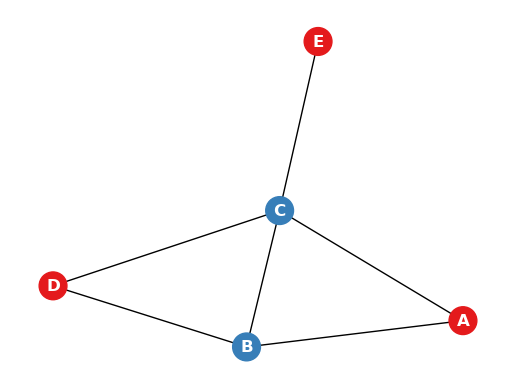

In [38]:
# using simulated annealer 
import neal     #dwave's annealer class
model = build_classical_ising(J)
bqm = model.to_bqm()
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=10)
samples = model.decode_sampleset(sampleset)
best_sample = min(samples, key=lambda s: s.energy)
colors_sa = [0 for _ in range(J.shape[0])]
for s,j in best_sample.sample.items():
    colors_sa[int(s[1:])] = j
print("Best solution: {} \n(colors: {})".format(best_sample.sample,colors_sa))

# plot classical solution
fig, ax = plt.subplots()
pos = nx.spring_layout(G, seed=168421) 
colorlist = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"] 
nx.draw_networkx(G, pos,
        node_color=[colorlist[col] for col in colors_sa],
        node_size=400, font_weight="bold", font_color="w",)
plt.axis("off")
plt.show()

In [47]:
# compare qaoa and class. solutions
print("Partitioning (classical):  ",
          np.array(colors_classical), "or", 
          np.bitwise_not(np.array(colors_classical))+2)
print("Partitioning (sim.anneal.):", np.array(colors_sa))
print("Partitioning (IPG-QAOA):   ", np.array(colors_ipg))

Partitioning (classical):   [0 1 1 0 0] or [1 0 0 1 1]
Partitioning (sim.anneal.): [0 1 1 0 0]
Partitioning (IPG-QAOA):    [1 1 0 1 1]
